# Introduction  

**!Recommend to view the notebook on Github!**  
Github Link : https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice2_Tox21_SVM/Assignment2_Tox21_SVM.ipynb

In this jupyter notebook, a toxicity of the molecular will be classified with the **Multi Layer Perceptron(MLP)** on **Tox21** dataset.  
**Tox21** dataset consists of molecular smile strings as inputs and binary labels as outputs.  

This notebook has following features  
- Convert smile string into _Morgan Fingerprints_(error handling enabled) with **RDkit**  
- Synthesis _insufficient class data_ by **imblearn SMOTE** algorithm in order to handle class imbalanced dataset 
- Support data spliting for _K-fold vallidation_ process easily
- Manage experiment and model _hyperparameters_ at once with **argparse**  
- _Visualize_ experiment results with minimal changes of codes with **seaborn** and **pandas Dataframe**  
- _Visualize_ experiment results with 95% _Confidence Intervals_

Throughout the notebook, there are **5** experiments with following investigation purpose.  
Note that **classification performance** includes _binary classification accuracy_ and _roc-auc metric._  
1. Influence of the **Number of hidden unit** toward **classification performance**.  
2. Influence of the **Number of hidden layer** in the SVC model toward **classification performance**.  
3. Influence of the **Number of hidden unit and layer** coefficient toward **classification performance**.
4. Influence of the **Dropout** rate toward **classification performance**.
5. Influence of the **L2 regularization** coefficient toward **classification performance**.
6. Influence of the **Dropout** and **L2 regularization** toward **classification performance**.


In [1]:
import time
from torch.multiprocessing import Pool, Process, set_start_method
from copy import deepcopy
import argparse
import sys
import traceback

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from utils import *


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.nbits = 2048
args.n_splits = 5
args.test_size = 0.2
args.shuffle = True


np.random.seed(args.seed)
torch.manual_seed(args.seed)
list_tox_type = ['nr-ahr', 'nr-ar-lbd', 
                 'nr-ar', 'nr-aromatase', 
                 'nr-er-lbd', 'nr-er', 
                 'nr-ppar-gamma', 'sr-are', 
                 'sr-atad5', 'sr-hse', 
                 'sr-mmp', 'sr-p53']


# Prepare Dataset by Generating Molecular Fingerprints  

Since the molecular information is provided within **smile** string form, we need to convert this strings into fixed-dimension feature vector. 
For this purpose, a **Morgan Fingerprints** methods was very suitable as it produces fixed-size vector with given dimension while capturing chemical information as well.  

You can produce fingerprint with specified dimension with arguments **nBits**  
Also, there are some **smile** string which cannot be converted into fingerprints so we excluded them during dataset preparation.  

`RDkit` Fingerprint Ref : http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [2]:
dict_partition = dict()
for tox_type in list_tox_type:
    args.tox_type = tox_type
    X, y = make_dataset(args)
    list_partition = make_partition(X, y, args)
    dict_partition[args.tox_type] = list_partition

## Dictionary saves experiment results with their hyperparatemr

In [3]:
exp_data = dict()

# MLP Model Architecture Define

The structure of the MLP mainly consists of linear layer, ReLU activation layer and dropout layer.  
At the end of the model, a sigmoid layer is adopted.

In [4]:
def construct_model(args):
    list_module = list()
    list_module += [nn.Linear(args.input_dim, args.hidden_dim), nn.ReLU()]

    if args.n_layer-2 > 0:
        for _ in range(args.n_layer-2):
            list_module.append(nn.Linear(hidden_dim, hidden_dim))
            list_module.append(nn.ReLU())
            if args.dropout_rate > 0:
                list_module.append(nn.Dropout(args.dropout_rate))
            
    list_module.append(nn.Linear(args.hidden_dim, args.output_dim))
    list_module.append(nn.Sigmoid())
    
    model = nn.Sequential(*list_module)
    return model 

# Experiment Template  

This section includes template code for launching individual experiments with given hyperparameters and experiment settings such as kernel type, C, gamma, fingerprint dimension, number of dataset fold and etc.  

- Data synthesis for insufficient class is shown during k-folding dataset.   
- Also, it includes function to execute each experiments in subprocess in order to maximize system resource utlization.
- **args** object contains all the hyperparameters and experiments settings to control the experiments.  

sklearn **k-fold** Ref : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold  
Using **SMOTE** Ref : https://beckernick.github.io/oversampling-modeling/  
Using Custom **Dataset** and **DataLoader** Ref : https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel 

In [5]:
def train(model, partition, optimizer, criterion, args):
    
    best_test_acc = 0
    best_roc_auc = 0
    cnt_iter = 0
    dict_train_loss = dict()
    dict_val_loss = dict()
    dict_acc_test = dict()
    dict_roc_auc_test = dict()
    
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    for epoch in range(args.epoch):
        epoch_train_loss = 0
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            model.train()
            optimizer.zero_grad()
            
            pred_y = model(X)
            pred_y.require_grad = False
            train_loss = criterion(pred_y, y)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            
            cnt_iter += 1
            
        dict_train_loss[cnt_iter/len(data_iter)] = train_loss.item()
        val_loss = validate(model, partition, criterion, args)
        dict_val_loss[cnt_iter/len(data_iter)] = val_loss
        test_acc, test_roc_auc = evaluate(model, partition, args)
        dict_acc_test[cnt_iter/len(data_iter)] = test_acc
        dict_roc_auc_test[cnt_iter/len(data_iter)] = test_roc_auc
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_roc_auc = test_roc_auc

    return model, pd.Series(dict_train_loss), pd.Series(dict_val_loss), pd.Series(dict_acc_test), pd.Series(dict_roc_auc_test), best_test_acc, best_roc_auc

def validate(model, partition, criterion, args):
    epoch_val_loss = 0
    model.eval()
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)
            pred_y = model(X)
            
            val_loss = criterion(pred_y, y)
            epoch_val_loss += val_loss.item()
            
    return epoch_val_loss / len(data_iter)

def evaluate(model, partition, args):
    model.eval()
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.batch_size,
        shuffle=False
    )
    
    list_y = list()
    list_pred_y = list()
    with torch.no_grad():
        list_accu = list()
        list_roc_auc = list()
        for batch_idx, batch in enumerate(data_iter):
            X, y = Variable(batch[0]), Variable(batch[1])
            X, y = X.to(args.device).float(), y.to(args.device).float()
            y = y.view(-1, 1)

            pred_y = model(X)
            target = y >= 0.5
            output = pred_y >= 0.5
            acc = float(output.eq(target).sum()) / target.numel()
            list_accu.append(acc)
            list_y += list(y.cpu().numpy())
            list_pred_y += list(pred_y.cpu().numpy())
    roc_auc = roc_auc_score(list_y, list_pred_y)

    return np.array(list_accu).mean(), roc_auc

In [6]:
def experiment(partition, args):
    model = construct_model(args)
    model.to(args.device)
    criterion = nn.BCELoss()
    
    # Initialize Optimizer
    if args.optim == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    model, train_loss, val_loss, acc_test, roc_auc_test, acc, roc_auc = train(model, partition, optimizer, criterion, args)
    return {'acc':acc, 'roc_auc':roc_auc, 'train_loss':train_loss, 'val_loss':val_loss, 'acc_test':acc_test, 'roc_auc_test':roc_auc_test}

In [7]:
def kfold_experiment(list_partition, args):    
    list_static = list()
    list_train_loss = list()
    list_val_loss = list()
    list_acc_test = list()
    list_roc_auc_test = list()
    list_result = list()
    for partition in list_partition:
        result = experiment(partition, args)
        list_static.append((result['acc'], result['roc_auc']))
        list_train_loss.append(result['train_loss'])
        list_val_loss.append(result['val_loss'])
        list_acc_test.append(result['acc_test'])
        list_roc_auc_test.append(result['roc_auc_test'])
        list_result.append(result)
        
    df = pd.DataFrame(list_static, columns=['acc', 'roc_auc'])
    train_loss = np.array(list_train_loss).mean(axis=0)
    val_loss = np.array(list_val_loss).mean(axis=0)
    acc_test = np.array(list_acc_test).mean(axis=0)
    roc_auc_test = np.array(list_roc_auc_test).mean(axis=0)
    
    for result in list_result:
        result.update({'acc_mean':df['acc'].mean(), 'acc_std':df['acc'].std(), 
                  'ra_mean':df['roc_auc'].mean(), 'ra_std':df['roc_auc'].std(),
                  'train_loss':train_loss, 'val_loss':val_loss,
                      'acc_test':acc_test, 'roc_auc_test':roc_auc_test})

    return list_result

In [8]:
def subproc_experiment(args):
    ts = time.time()
#     try:
    list_partition = args.list_partition
    list_result = kfold_experiment(list_partition, args)
    te = time.time()

    for result in list_result:
        result.update({'elapsed':te-ts})
        temp_args = deepcopy(vars(args))
        del temp_args['list_partition']
        result.update(temp_args)
    """
    except Exception as e:
        args.msg = traceback.print_tb(e.__traceback__)
    """
    return list_result
    
def callback_experiment(list_result):
    
    result = list_result[0] 
    output = "Acc Mean: {:0.3f} Acc STD: {:0.3f} RA Mean: {:0.3f} RA STD: {:0.3f} Elapsed: {:3.1f}"
    output = output.format(result['acc_mean'],
                           result['acc_std'],
                           result['ra_mean'],
                           result['ra_std'],
                           result['elapsed'])
    print(output)
    
    global exp_data
    list_experiments = exp_data.get(args.exp_name, [])
    list_experiments += list_result

# Test Experiment

In [10]:
args.input_dim = 2048
args.hidden_dim = 128
args.batch_size = 128
args.output_dim = 1
args.n_layer = 2
args.dropout_rate = 0.2
args.lr = 0.01
args.l2_coef = 0
args.optim = 'ADAM'
args.epoch = 10
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.exp_name = 'exp_test'
args.list_partition = dict_partition['nr-ahr']
result = subproc_experiment(args)
callback_experiment(result)

Acc Mean: 0.950 Acc STD: 0.008 RA Mean: 0.923 RA STD: 0.020 Elapsed: 10.4


# Experiemnt1. Effect of Hidden Unit

In this experiment, molecular fingerprints would be calculated with different nbits values. If the value of the nbits is too low, then fingerprint vector would not represent important information. Otherwise, if the value of the nbits is too high, then fingerprint vector would be sparse so that model would less capture important feature from the fingerprint vector  

**Pandas Dataframe** construction Ref : http://pbpython.com/pandas-list-dict.html  
**Pyplot Grid** Ref : https://matplotlib.org/users/gridspec.html  

In [11]:
%%time
args.exp_name = 'exp_hidden_dim'
args.input_dim = 2048
args.output_dim = 1
args.n_layer = 2
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

exp_data['exp_hidden_dim'] = list()
list_hidden_dim = [1, 4, 16, 64, 256, 1024, 4096]

# pool = Pool(processes=14)
for tox_type in list_tox_type[:3]:
    for hidden_dim in list_hidden_dim:
        args.tox_type = tox_type
        args.hidden_dim = hidden_dim
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.925 Acc STD: 0.013 RA Mean: 0.909 RA STD: 0.019 Elapsed: 19.9
Acc Mean: 0.937 Acc STD: 0.007 RA Mean: 0.914 RA STD: 0.023 Elapsed: 20.3
Acc Mean: 0.944 Acc STD: 0.009 RA Mean: 0.911 RA STD: 0.023 Elapsed: 19.6
Acc Mean: 0.946 Acc STD: 0.009 RA Mean: 0.910 RA STD: 0.023 Elapsed: 17.7
Acc Mean: 0.950 Acc STD: 0.009 RA Mean: 0.914 RA STD: 0.021 Elapsed: 19.4
Acc Mean: 0.952 Acc STD: 0.009 RA Mean: 0.918 RA STD: 0.020 Elapsed: 19.5
Acc Mean: 0.953 Acc STD: 0.008 RA Mean: 0.926 RA STD: 0.018 Elapsed: 26.1
Acc Mean: 0.983 Acc STD: 0.005 RA Mean: 0.915 RA STD: 0.034 Elapsed: 22.9
Acc Mean: 0.985 Acc STD: 0.005 RA Mean: 0.924 RA STD: 0.030 Elapsed: 23.0
Acc Mean: 0.986 Acc STD: 0.003 RA Mean: 0.923 RA STD: 0.032 Elapsed: 22.9
Acc Mean: 0.987 Acc STD: 0.003 RA Mean: 0.921 RA STD: 0.033 Elapsed: 23.0
Acc Mean: 0.988 Acc STD: 0.003 RA Mean: 0.922 RA STD: 0.031 Elapsed: 23.2
Acc Mean: 0.989 Acc STD: 0.003 RA Mean: 0.921 RA STD: 0.033 Elapsed: 23.2
Acc Mean: 0.989 Acc STD: 0.003 RA Mean

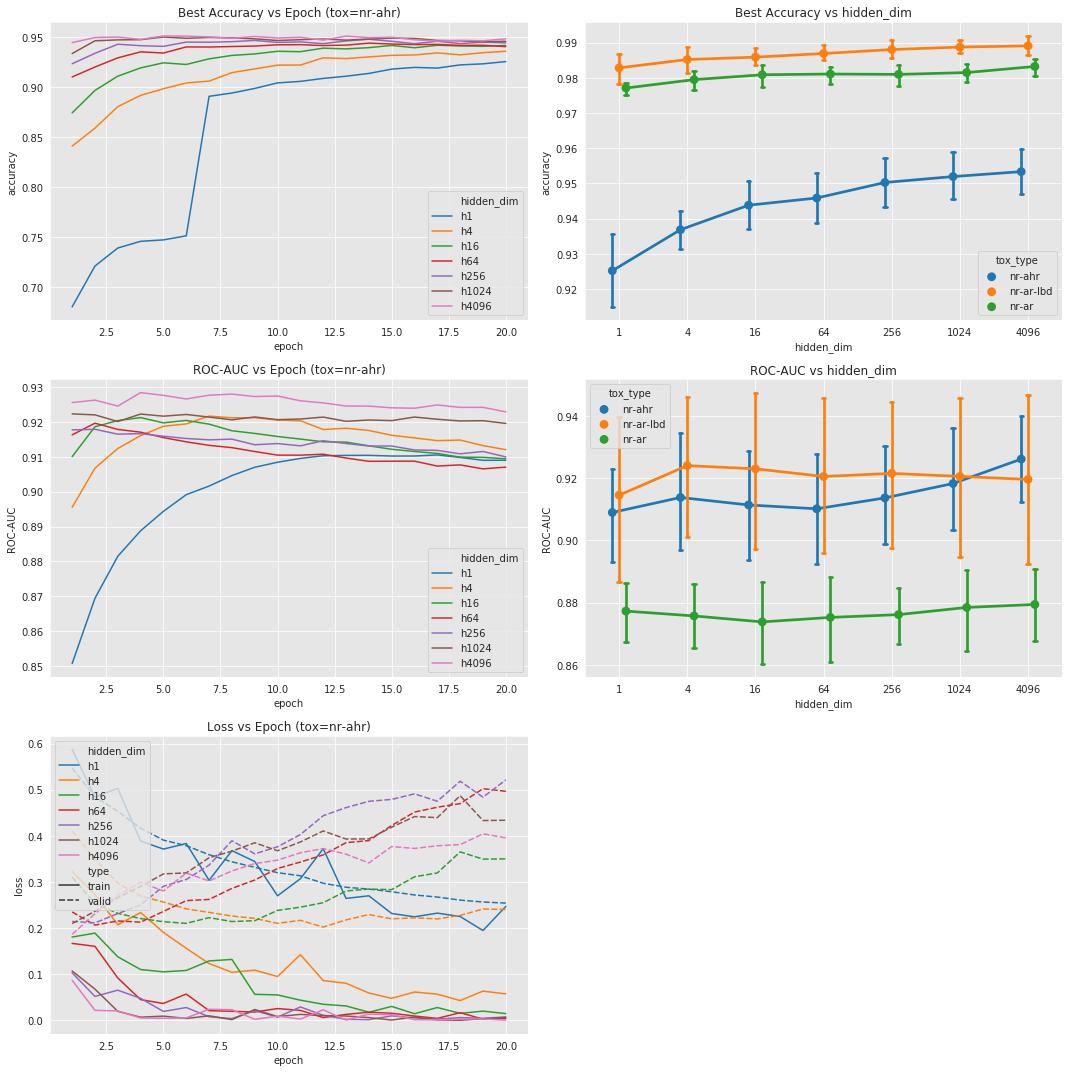

In [118]:
exp_name = 'exp_hidden_dim'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'tox_type', 'hidden_dim']]

variable = 'hidden_dim'
variable2 = 'tox_type'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for result in exp_data[exp_name]:
        if result[variable] == value and result['tox_type'] == 'nr-ahr':
            for i, data in enumerate(result['train_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value)})
            for i, data in enumerate(result['val_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value)})
            for i, data in enumerate(result['acc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value)})
            for i, data in enumerate(result['roc_auc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value)})
            break
            
df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig = plt.figure(figsize=(15,15))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
gs = gridspec.GridSpec(3, 2)

ax = plt.subplot(gs[0,1])
grid = sns.pointplot(x="hidden_dim", y="acc", hue="tox_type", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax)
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)

ax = plt.subplot(gs[0,0])
df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_acc, ax=ax)
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

ax = plt.subplot(gs[1,1])
grid = sns.pointplot(x="hidden_dim", y="roc_auc", hue="tox_type", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax)
grid.set_title("ROC-AUC vs {}".format(variable))
grid.set_ylabel("ROC-AUC")
grid.grid(True)

ax = plt.subplot(gs[1,0])
df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_roc_auc, ax=ax)
grid.set_title("ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("ROC-AUC")

ax = plt.subplot(gs[2,0])
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style='type', data=df_loss, ax=ax)
grid.set_title("Loss vs Epoch (tox=nr-ahr)")

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over dimension of the fingerprints.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the lower row are plotted with heatmap to deliver exact accuracy and roc-auc value.  

**Experiment Settings.**   
- Tested dimensions were [1, 4, 16, 64, 256, 1024, 2048, 4096] and higher dimensions were not tested since it took long computation time.  
- All 12 toxicity types were tested in order to observe the general effect of vector size.  
- A linear kernel was used due to its superior computation speed. C and gamma value were selected as 1.0 and 1/n_feature, respectively. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**    
- Both accuracy and roc-auc are increased while the dimension of the fingerprints increase. 
- When vector size is 1 and 4, auc-roc is almost 0.5 which means that the classifier cannot distinguish the input which is reasonable result since too many information are condensed into just few elements.  
- It is notable that accuracy and roc-auc were around 0.9 when vector size is more than 2048 without any hyperparameter optimization 

# Experiment2. Effect of Hidden Layer

In [69]:
%%time
args.exp_name = 'exp_n_layer'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp_data[args.exp_name] = list()
list_n_layer = [2,3,4,5,6,7,8,9,10]

# pool = Pool(processes=14)
for tox_type in list_tox_type[:3]:
    for n_layer in list_n_layer:
        args.tox_type = tox_type
        args.n_layer = n_layer
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.952 Acc STD: 0.008 RA Mean: 0.920 RA STD: 0.019 Elapsed: 19.8
Acc Mean: 0.956 Acc STD: 0.006 RA Mean: 0.926 RA STD: 0.014 Elapsed: 22.9
Acc Mean: 0.957 Acc STD: 0.008 RA Mean: 0.922 RA STD: 0.020 Elapsed: 25.3
Acc Mean: 0.958 Acc STD: 0.008 RA Mean: 0.916 RA STD: 0.018 Elapsed: 27.8
Acc Mean: 0.958 Acc STD: 0.008 RA Mean: 0.927 RA STD: 0.016 Elapsed: 30.0
Acc Mean: 0.790 Acc STD: 0.376 RA Mean: 0.845 RA STD: 0.193 Elapsed: 32.7
Acc Mean: 0.608 Acc STD: 0.449 RA Mean: 0.674 RA STD: 0.240 Elapsed: 34.5
Acc Mean: 0.773 Acc STD: 0.368 RA Mean: 0.754 RA STD: 0.231 Elapsed: 36.8
Acc Mean: 0.624 Acc STD: 0.462 RA Mean: 0.763 RA STD: 0.240 Elapsed: 37.2
Acc Mean: 0.989 Acc STD: 0.003 RA Mean: 0.922 RA STD: 0.032 Elapsed: 21.0
Acc Mean: 0.989 Acc STD: 0.002 RA Mean: 0.919 RA STD: 0.038 Elapsed: 22.8
Acc Mean: 0.989 Acc STD: 0.002 RA Mean: 0.919 RA STD: 0.035 Elapsed: 28.8
Acc Mean: 0.990 Acc STD: 0.002 RA Mean: 0.920 RA STD: 0.030 Elapsed: 31.3
Acc Mean: 0.989 Acc STD: 0.003 RA Mean

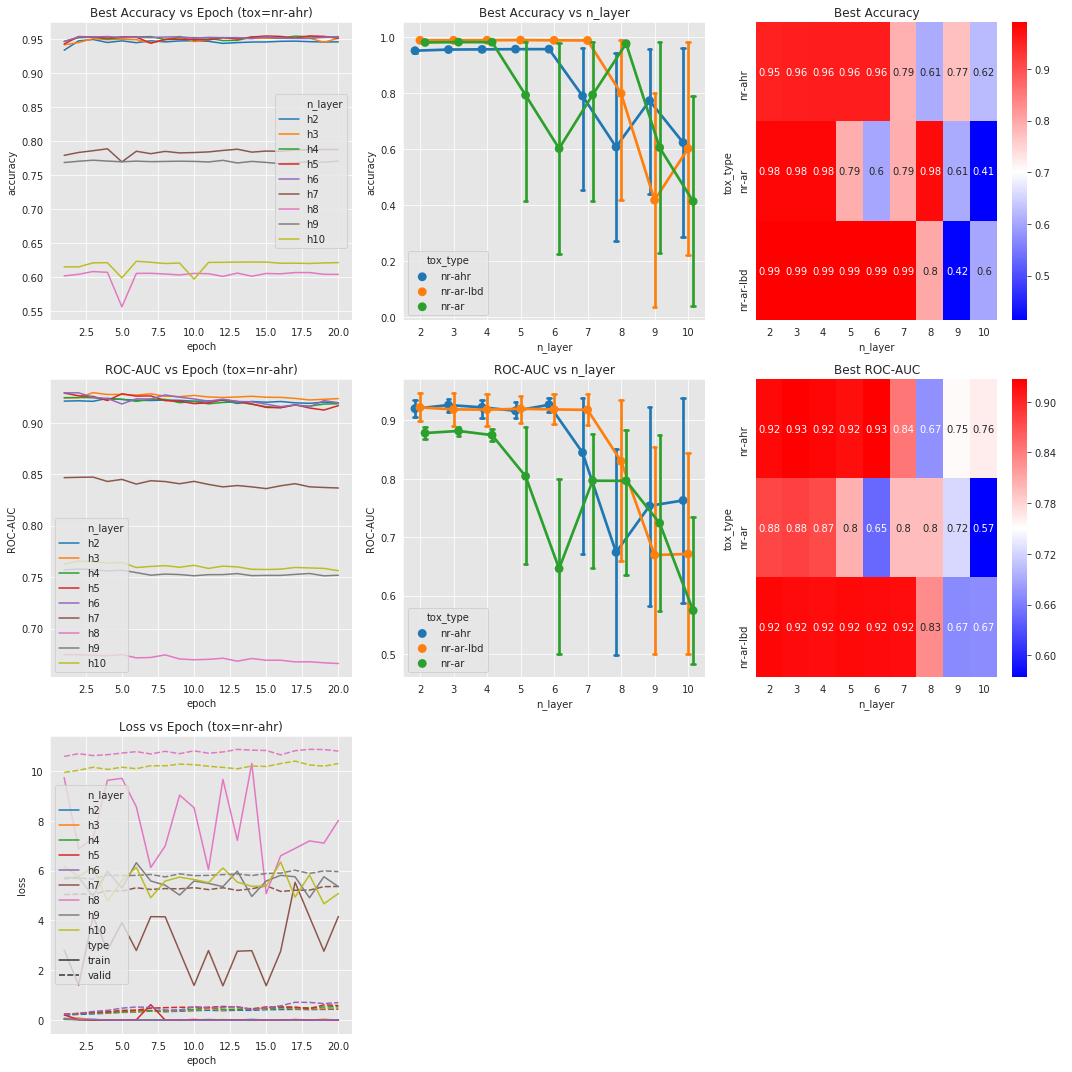

In [119]:
exp_name = 'exp_n_layer'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'tox_type', 'n_layer']]

variable = 'n_layer'
variable2 = 'tox_type'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for result in exp_data[exp_name]:
        if result[variable] == value and result['tox_type'] == 'nr-ahr':
            for i, data in enumerate(result['train_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value)})
            for i, data in enumerate(result['val_loss']):
                list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value)})
            for i, data in enumerate(result['acc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value)})
            for i, data in enumerate(result['roc_auc_test']):
                list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value)})
            break
            
df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

grid = sns.pointplot(x="n_layer", y="acc", hue="tox_type", data=df, ci=95, capsize=0.1, dodge=0.3, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr')
grid.set_title("Best Accuracy")

grid = sns.pointplot(x="n_layer", y="roc_auc", hue="tox_type", data=df, ci=95, capsize=0.1, dodge=0.3, ax=ax[1][1])
grid.set_title("ROC-AUC vs {}".format(variable))
grid.set_ylabel("ROC-AUC")
grid.grid(True)

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, data=df_roc_auc, ax=ax[1][0])
grid.set_title("ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("ROC-AUC")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr')
grid.set_title("Best ROC-AUC")

grid = sns.lineplot(x='epoch', y='loss', hue=variable, style='type', data=df_loss, ax=ax[2][0])
grid.set_title("Loss vs Epoch (tox=nr-ahr)")

ax[-1,-1].axis('off')
ax[-1,-2].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

# Experiment3. Effect of Hidden Unit and Hidden Layer

In [61]:
%%time
args.exp_name = 'exp_hidden_dim_layer'
args.input_dim = 2048
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'

exp_data['exp_hidden_dim_layer'] = list()
list_hidden_dim = [16, 64, 256, 1024]
list_n_layer = [2,3,4,5,6]

# pool = Pool(processes=14)
for hidden_dim in list_hidden_dim[:]:
    for n_layer in list_n_layer:
        args.hidden_dim = hidden_dim
        args.n_layer = n_layer
        args.list_partition = dict_partition[args.tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
#         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.917 Acc STD: 0.013 RA Mean: 0.910 RA STD: 0.022 Elapsed: 20.5
Acc Mean: 0.896 Acc STD: 0.017 RA Mean: 0.656 RA STD: 0.214 Elapsed: 21.2
Acc Mean: 0.883 Acc STD: 0.001 RA Mean: 0.500 RA STD: 0.000 Elapsed: 25.4
Acc Mean: 0.577 Acc STD: 0.420 RA Mean: 0.500 RA STD: 0.000 Elapsed: 27.7
Acc Mean: 0.576 Acc STD: 0.420 RA Mean: 0.500 RA STD: 0.000 Elapsed: 29.7
Acc Mean: 0.932 Acc STD: 0.013 RA Mean: 0.914 RA STD: 0.023 Elapsed: 20.7
Acc Mean: 0.943 Acc STD: 0.009 RA Mean: 0.908 RA STD: 0.022 Elapsed: 23.1
Acc Mean: 0.942 Acc STD: 0.010 RA Mean: 0.899 RA STD: 0.030 Elapsed: 26.0
Acc Mean: 0.944 Acc STD: 0.009 RA Mean: 0.902 RA STD: 0.028 Elapsed: 26.1
Acc Mean: 0.920 Acc STD: 0.034 RA Mean: 0.752 RA STD: 0.231 Elapsed: 25.3
Acc Mean: 0.944 Acc STD: 0.009 RA Mean: 0.911 RA STD: 0.022 Elapsed: 18.2
Acc Mean: 0.946 Acc STD: 0.008 RA Mean: 0.904 RA STD: 0.025 Elapsed: 21.9
Acc Mean: 0.947 Acc STD: 0.008 RA Mean: 0.903 RA STD: 0.026 Elapsed: 26.0
Acc Mean: 0.948 Acc STD: 0.008 RA Mean

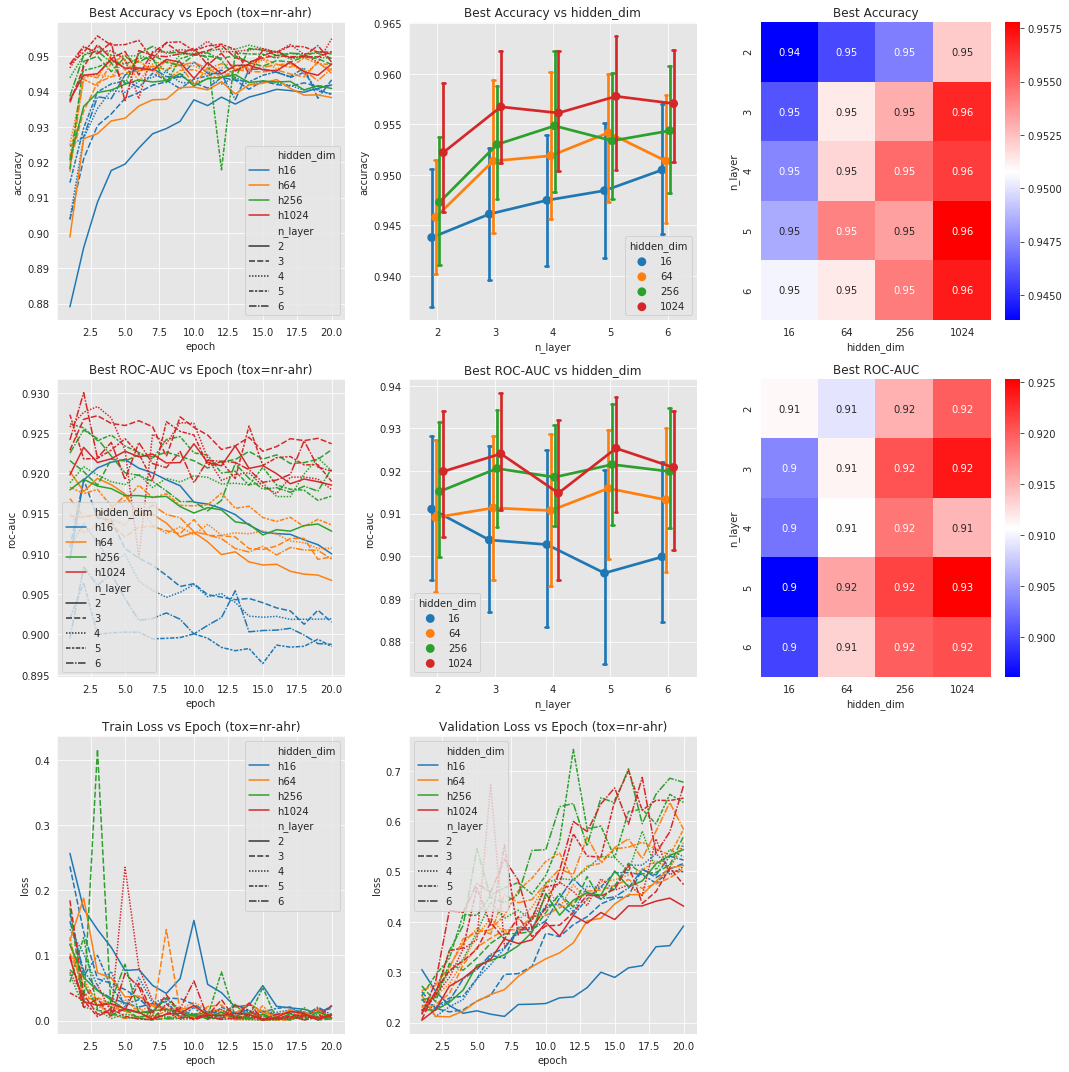

In [120]:
exp_name = 'exp_hidden_dim_layer'

df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'hidden_dim']]
df = df.loc[df['hidden_dim'] != 1]
df = df.loc[df['hidden_dim'] != 4]

variable = 'hidden_dim'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value), variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x="n_layer", y="acc", hue="hidden_dim", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr')
grid.set_title("Best Accuracy")

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x="n_layer", y="roc_auc", hue="hidden_dim", data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr')
grid.set_title("Best ROC-AUC")

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Validation Loss vs Epoch (tox=nr-ahr)")

ax[-1, -1].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over type of the kernel.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the lower row are plotted with heatmap to deliver exact accuracy and roc-auc value.  

**Experiment Settings.**  
- Tested kernel were ['linear', 'poly', 'rbf', 'sigmoid'].  
- All 12 toxicity types were tested in order to observe the general effect of kernel type.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default C and gamma value were selected as 1.0 and 1/n_feature, respectively. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- The performance of accuracy and roc-auc were decreased in order of 'rbf' > 'poly' > 'linear' > 'sigmoid'. 
- The order of the performance among different tox_type was almost consisent aganist the kernel type that it might  imply each tox_type dataset has it own data complexity.  

# Experiment4. Effect of Dropout Rate

In [81]:
%%time
args.exp_name = 'exp_dropout_rate'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.lr = 0.001
args.l2_coef = 0
args.optim = 'RMSProp'
args.epoch = 20
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_dp_rate = [i*0.2 for i in range(5)]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for dp_rate in list_dp_rate:
        args.n_layer = n_layer
        args.dropout_rate = dp_rate
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
    #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.982 Acc STD: 0.004 RA Mean: 0.879 RA STD: 0.012 Elapsed: 23.3
Acc Mean: 0.982 Acc STD: 0.004 RA Mean: 0.878 RA STD: 0.017 Elapsed: 24.0
Acc Mean: 0.982 Acc STD: 0.005 RA Mean: 0.876 RA STD: 0.018 Elapsed: 23.8
Acc Mean: 0.982 Acc STD: 0.003 RA Mean: 0.877 RA STD: 0.016 Elapsed: 24.2
Acc Mean: 0.981 Acc STD: 0.004 RA Mean: 0.879 RA STD: 0.011 Elapsed: 24.1
Acc Mean: 0.983 Acc STD: 0.004 RA Mean: 0.874 RA STD: 0.011 Elapsed: 26.9
Acc Mean: 0.983 Acc STD: 0.003 RA Mean: 0.876 RA STD: 0.015 Elapsed: 35.0
Acc Mean: 0.982 Acc STD: 0.004 RA Mean: 0.874 RA STD: 0.013 Elapsed: 35.0
Acc Mean: 0.983 Acc STD: 0.004 RA Mean: 0.874 RA STD: 0.013 Elapsed: 34.0
Acc Mean: 0.983 Acc STD: 0.004 RA Mean: 0.880 RA STD: 0.013 Elapsed: 33.9
Acc Mean: 0.794 Acc STD: 0.422 RA Mean: 0.796 RA STD: 0.166 Elapsed: 42.8
Acc Mean: 0.794 Acc STD: 0.421 RA Mean: 0.798 RA STD: 0.167 Elapsed: 52.3
Acc Mean: 0.982 Acc STD: 0.004 RA Mean: 0.880 RA STD: 0.012 Elapsed: 50.4
Acc Mean: 0.982 Acc STD: 0.002 RA Mean

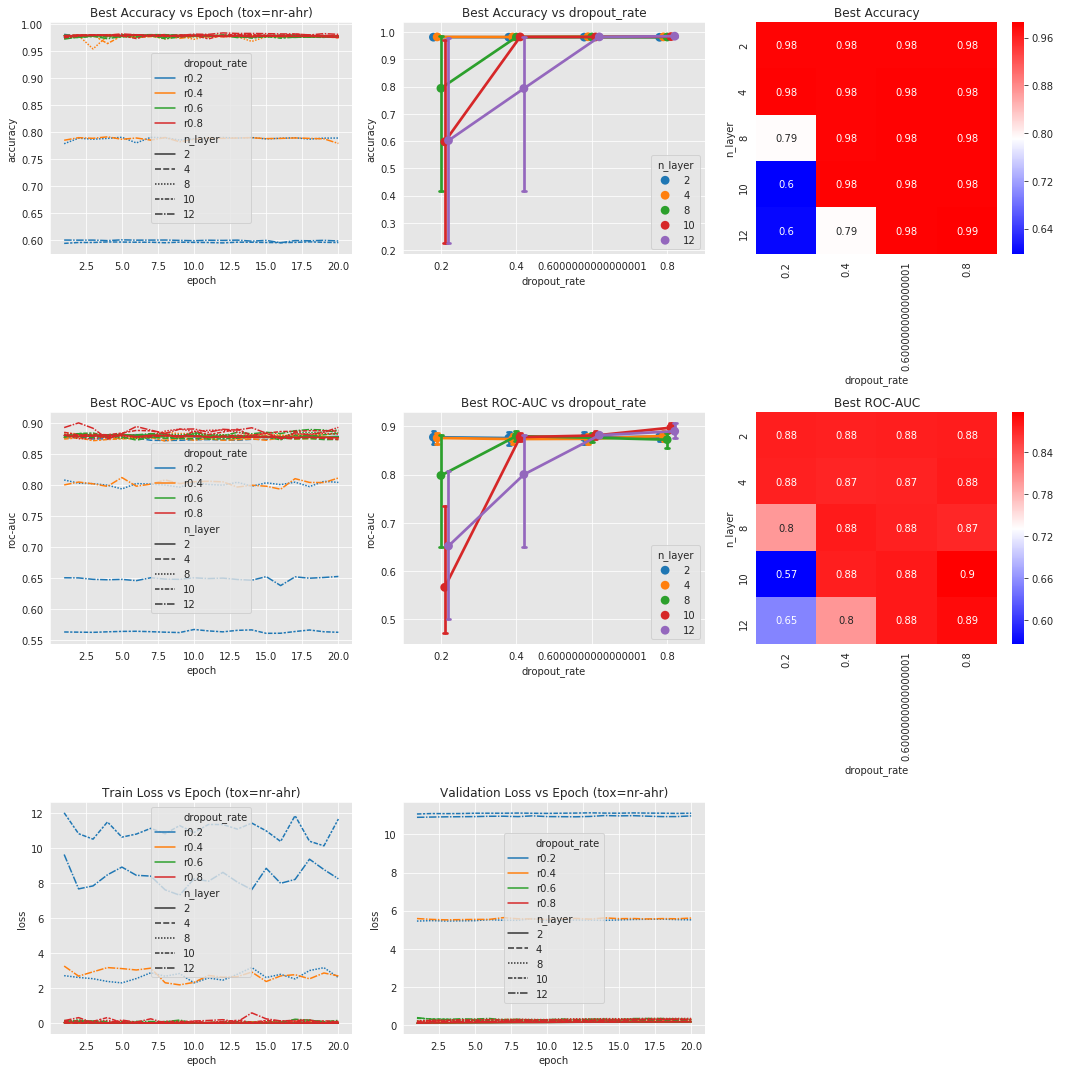

In [125]:
exp_name = 'exp_dropout_rate'

df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'dropout_rate']]
df = df.loc[df['dropout_rate'] > 0]


variable = 'dropout_rate'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'r'+str(value)[:3], variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'r'+str(value)[:3], variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x=variable, y="acc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='bwr')
grid.set_title("Best Accuracy")

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x=variable, y="roc_auc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)

grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='bwr')
grid.set_title("Best ROC-AUC")

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Validation Loss vs Epoch (tox=nr-ahr)")
ax[2][2].axis('off')

plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over C value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**  
- Tested C values were [1,4,7,10,13,16,19,22,25,28,31,34,37].  
- 4 kernel types: ['linear', 'poly', 'rbf', 'sigmoid'] were tested in order to observe the general effect of C towrad a kernel type.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default gamma value was selected as 1/n_feature. 
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- In 'poly' and 'rbf' the performance of accuracy and roc-auc were increased with C value. 
- On the other hands, in 'sigmoid', 'linear' the accuracy was unstable with C value.  
- In 'sigmoid', 'linear' the roc-auc seems decreased with C value. 

# Experiment5. Effect of L2 regularization

In [128]:
%%time
args.exp_name = 'exp_l2_coef'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.dropout_rate = 0.0
args.lr = 0.001
args.optim = 'RMSProp'
args.epoch = 2
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_l2_coef = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for l2_coef in list_l2_coef:
        args.n_layer = n_layer
        args.l2_coef = l2_coef
        args.list_partition = dict_partition[tox_type]
        result = subproc_experiment(args)
        callback_experiment(result)
    #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.980 Acc STD: 0.004 RA Mean: 0.879 RA STD: 0.012 Elapsed: 2.6
Acc Mean: 0.980 Acc STD: 0.004 RA Mean: 0.895 RA STD: 0.019 Elapsed: 2.7
Acc Mean: 0.976 Acc STD: 0.003 RA Mean: 0.895 RA STD: 0.017 Elapsed: 2.7
Acc Mean: 0.967 Acc STD: 0.003 RA Mean: 0.873 RA STD: 0.014 Elapsed: 2.4
Acc Mean: 0.947 Acc STD: 0.011 RA Mean: 0.784 RA STD: 0.024 Elapsed: 2.4
Acc Mean: 0.865 Acc STD: 0.212 RA Mean: 0.217 RA STD: 0.036 Elapsed: 2.5
Acc Mean: 0.983 Acc STD: 0.004 RA Mean: 0.881 RA STD: 0.010 Elapsed: 2.9
Acc Mean: 0.981 Acc STD: 0.002 RA Mean: 0.887 RA STD: 0.016 Elapsed: 2.9
Acc Mean: 0.981 Acc STD: 0.004 RA Mean: 0.883 RA STD: 0.013 Elapsed: 2.9
Acc Mean: 0.969 Acc STD: 0.010 RA Mean: 0.888 RA STD: 0.010 Elapsed: 2.9
Acc Mean: 0.960 Acc STD: 0.001 RA Mean: 0.500 RA STD: 0.000 Elapsed: 2.9
Acc Mean: 0.776 Acc STD: 0.411 RA Mean: 0.500 RA STD: 0.000 Elapsed: 2.9
Acc Mean: 0.971 Acc STD: 0.011 RA Mean: 0.716 RA STD: 0.218 Elapsed: 4.5
Acc Mean: 0.977 Acc STD: 0.005 RA Mean: 0.880 RA ST

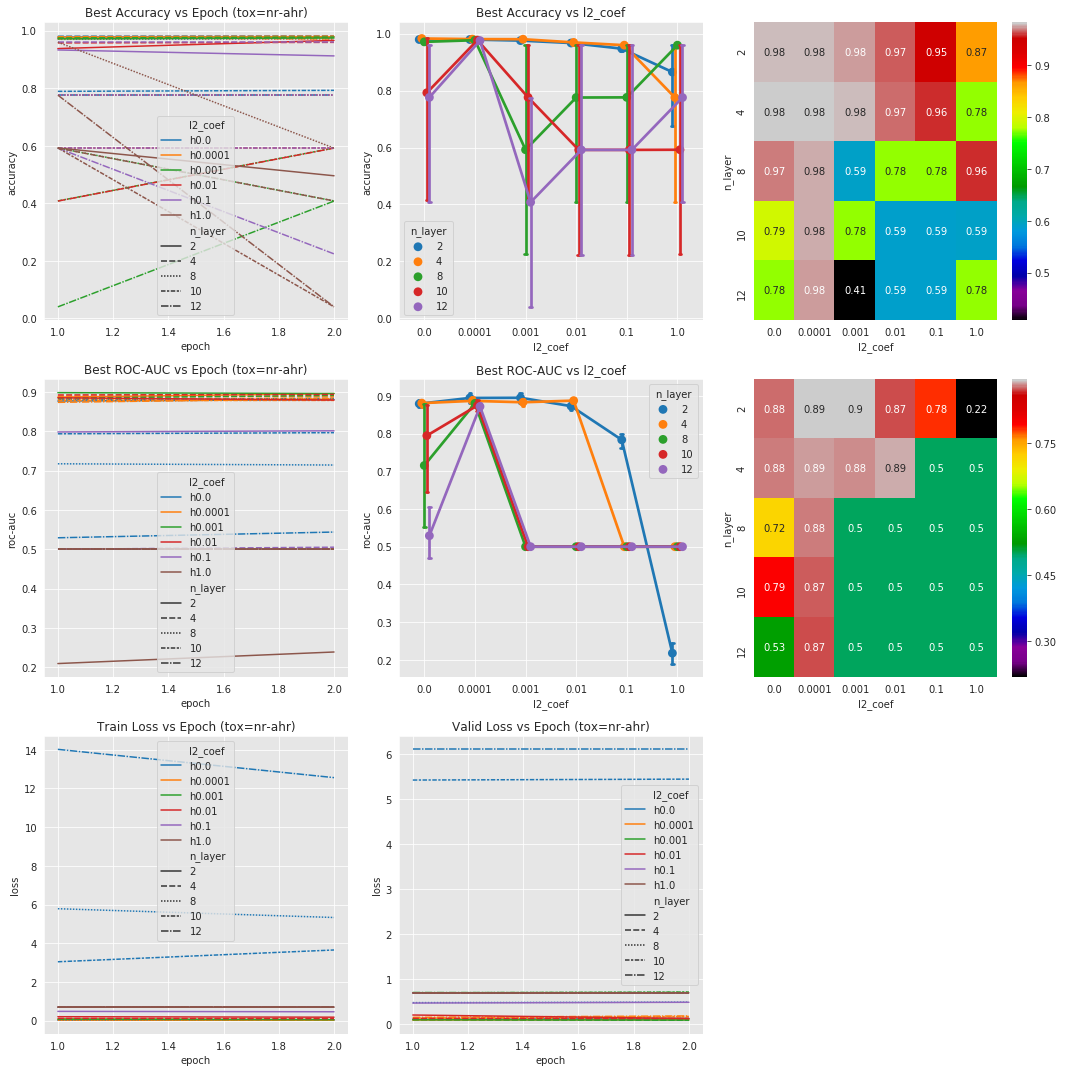

In [138]:
exp_name = 'exp_l2_coef'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'l2_coef']]


variable = 'l2_coef'
variable2 = 'n_layer'
list_loss = list()
list_test = list()

for value in df[variable].unique():
    for value2 in df[variable2].unique():
        for result in exp_data[exp_name]:
            if result[variable] == value and result[variable2] == value2:
                for i, data in enumerate(result['train_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'train', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['val_loss']):
                    list_loss.append({'epoch':i+1, 'loss':data, 'type':'valid', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['acc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'acc', variable:'h'+str(value), variable2:value2})
                for i, data in enumerate(result['roc_auc_test']):
                    list_test.append({'epoch':i+1, 'test':data, 'type':'roc_auc', variable:'h'+str(value), variable2:value2})
                break

df_loss = pd.DataFrame(list_loss)
df_test = pd.DataFrame(list_test)


fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = df_test.loc[df_test['type'] == 'acc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_acc, ax=ax[0][0])
grid.set_title("Best Accuracy vs Epoch (tox=nr-ahr)")
grid.set_ylabel("accuracy")

df_acc = pd.DataFrame(df.groupby([variable2, variable])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_acc = df_acc.pivot(index=variable2, columns=variable, values='acc')

grid = sns.pointplot(x=variable, y="acc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[0][1])
grid.set_title("Best Accuracy vs {}".format(variable))
grid.set_ylabel("accuracy")
grid.grid(True)
grid = sns.heatmap(df_acc, annot=True, ax=ax[0][2], cmap='nipy_spectral')

df_roc_auc = df_test.loc[df_test['type'] == 'roc_auc']
grid = sns.lineplot(x='epoch', y='test', hue=variable, style=variable2, data=df_roc_auc, ax=ax[1][0])
grid.set_title("Best ROC-AUC vs Epoch (tox=nr-ahr)")
grid.set_ylabel("roc-auc")

df_roc_auc = pd.DataFrame(df.groupby([variable2, variable])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)
df_roc_auc = df_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')

grid = sns.pointplot(x=variable, y="roc_auc", hue=variable2, data=df, ci=95, capsize=0.05, dodge=0.2, ax=ax[1][1])
grid.set_title("Best ROC-AUC vs {}".format(variable))
grid.set_ylabel("roc-auc")
grid.grid(True)
grid = sns.heatmap(df_roc_auc, annot=True, ax=ax[1][2], cmap='nipy_spectral')

df_train = df_loss.loc[df_loss['type'] == 'train']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_train, ax=ax[2][0])
grid.set_title("Train Loss vs Epoch (tox=nr-ahr)")

df_valid = df_loss.loc[df_loss['type'] == 'valid']
grid = sns.lineplot(x='epoch', y='loss', hue=variable, style=variable2, data=df_valid, ax=ax[2][1])
grid.set_title("Valid Loss vs Epoch (tox=nr-ahr)")

ax[-1,-1].axis('off')
plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over gamma value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**  
- Tested C values were 10^[-4, -3, -2, -1, 0, 1, 2, 3, 4].  
- 3 kernel types: ['poly', 'rbf', 'sigmoid'] were tested in order to observe the general effect of gamma towrad a kernel type('linear' was excluded since it does not have gamma parameter).  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Default C value was selected as 1.0. 
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- Overally, there were some interval of the gamma value where the performance is maximized for each kernel type.  
- For example, 'poly' and 'rbf' were maximized around 0.1~10.0 and 'sigmoid' was maximized around 0.01.  
- 'sigmoid' was worst kernel type. 

# Experiment6. Finding Best Dropout Rate and L2 Regularization

In [140]:
%%time
args.exp_name = 'exp_dropout_l2'
args.input_dim = 2048
args.hidden_dim = 1024
args.output_dim = 1
args.lr = 0.001
args.optim = 'RMSProp'
args.epoch = 2
args.batch_size=128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.tox_type = 'nr-ahr'
exp_data[args.exp_name] = list()
list_l2_coef = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
list_dropout_rate = [i*0.2 for i in range(5)]
list_n_layer = [2,4,8,10,12]

# pool = Pool(processes=14)
for n_layer in list_n_layer:
    for dropout_rate in list_dropout_rate:
        for l2_coef in list_l2_coef:
            args.dropout_rate = dropout_rate
            args.n_layer = n_layer
            args.l2_coef = l2_coef
            args.list_partition = dict_partition[tox_type]
            result = subproc_experiment(args)
            callback_experiment(result)
        #         pool.apply_async(subproc_experiment, args = (args,), callback=callback_experiment)

# pool.close()
# pool.join()

Acc Mean: 0.980 Acc STD: 0.003 RA Mean: 0.876 RA STD: 0.014 Elapsed: 2.6
Acc Mean: 0.979 Acc STD: 0.004 RA Mean: 0.890 RA STD: 0.010 Elapsed: 2.7
Acc Mean: 0.975 Acc STD: 0.004 RA Mean: 0.895 RA STD: 0.012 Elapsed: 2.7
Acc Mean: 0.949 Acc STD: 0.016 RA Mean: 0.886 RA STD: 0.015 Elapsed: 2.6
Acc Mean: 0.949 Acc STD: 0.019 RA Mean: 0.788 RA STD: 0.047 Elapsed: 2.6
Acc Mean: 0.408 Acc STD: 0.503 RA Mean: 0.202 RA STD: 0.017 Elapsed: 2.7
Acc Mean: 0.980 Acc STD: 0.003 RA Mean: 0.877 RA STD: 0.013 Elapsed: 2.4
Acc Mean: 0.980 Acc STD: 0.004 RA Mean: 0.889 RA STD: 0.009 Elapsed: 2.5
Acc Mean: 0.973 Acc STD: 0.009 RA Mean: 0.896 RA STD: 0.012 Elapsed: 2.6
Acc Mean: 0.963 Acc STD: 0.011 RA Mean: 0.880 RA STD: 0.016 Elapsed: 2.4
Acc Mean: 0.893 Acc STD: 0.111 RA Mean: 0.793 RA STD: 0.029 Elapsed: 2.4
Acc Mean: 0.609 Acc STD: 0.481 RA Mean: 0.216 RA STD: 0.023 Elapsed: 2.4
Acc Mean: 0.980 Acc STD: 0.004 RA Mean: 0.880 RA STD: 0.012 Elapsed: 2.3
Acc Mean: 0.979 Acc STD: 0.004 RA Mean: 0.887 RA ST

Acc Mean: 0.776 Acc STD: 0.411 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.7
Acc Mean: 0.975 Acc STD: 0.007 RA Mean: 0.881 RA STD: 0.014 Elapsed: 6.5
Acc Mean: 0.978 Acc STD: 0.004 RA Mean: 0.877 RA STD: 0.017 Elapsed: 6.8
Acc Mean: 0.964 Acc STD: 0.009 RA Mean: 0.637 RA STD: 0.163 Elapsed: 6.7
Acc Mean: 0.776 Acc STD: 0.411 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.7
Acc Mean: 0.592 Acc STD: 0.504 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.7
Acc Mean: 0.408 Acc STD: 0.504 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.7
Acc Mean: 0.417 Acc STD: 0.515 RA Mean: 0.647 RA STD: 0.202 Elapsed: 5.8
Acc Mean: 0.970 Acc STD: 0.007 RA Mean: 0.866 RA STD: 0.036 Elapsed: 6.2
Acc Mean: 0.960 Acc STD: 0.001 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.2
Acc Mean: 0.224 Acc STD: 0.411 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.1
Acc Mean: 0.408 Acc STD: 0.504 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.2
Acc Mean: 0.408 Acc STD: 0.504 RA Mean: 0.500 RA STD: 0.000 Elapsed: 6.2
Acc Mean: 0.603 Acc STD: 0.514 RA Mean: 0.727 RA ST

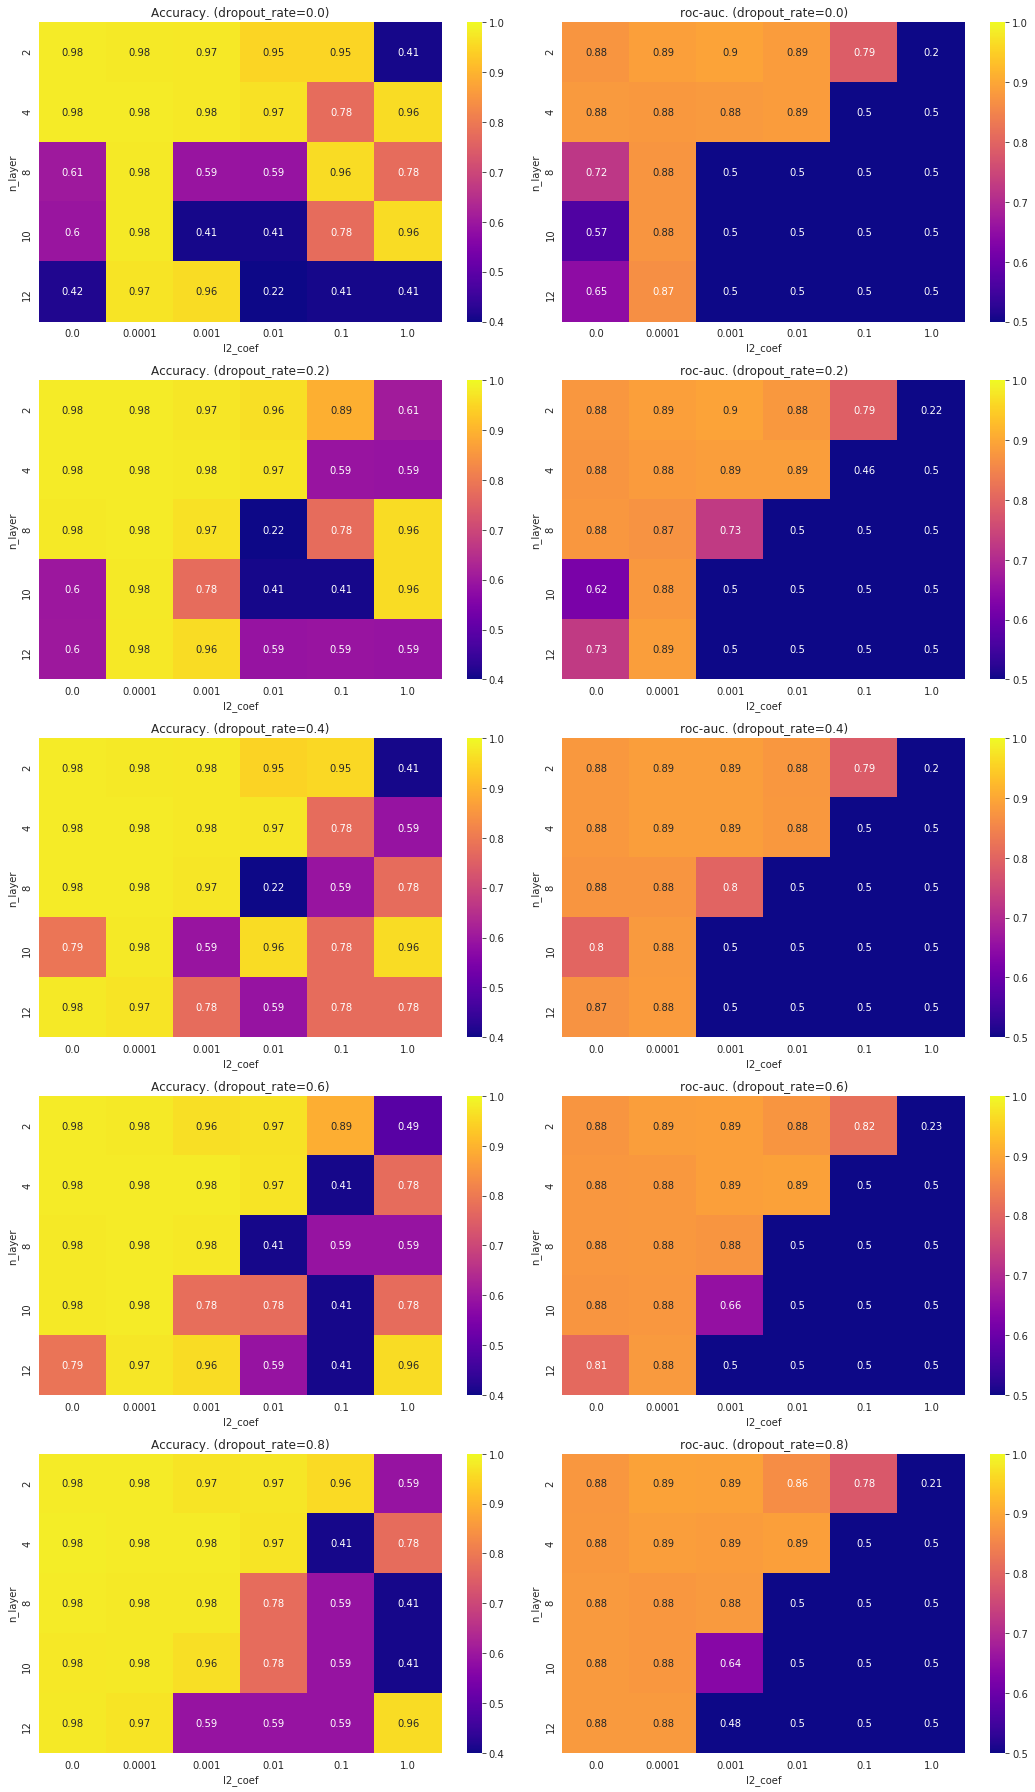

In [162]:
exp_name = 'exp_dropout_l2'
df = pd.DataFrame(exp_data[exp_name])
df = df[['acc', 'roc_auc', 'n_layer', 'l2_coef', 'dropout_rate']]

variable = 'l2_coef'
variable2 = 'n_layer'
variable3 = 'dropout_rate'
list_loss = list()
list_test = list()



fig, ax = plt.subplots(len(df[variable3].unique()), 2)
fig.set_size_inches(15, 5*len(df[variable3].unique()))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_acc = pd.DataFrame(df.groupby([variable, variable2, variable3])['acc'].mean())
df_acc.reset_index(level=df_acc.index.names, inplace=True)
df_roc_auc = pd.DataFrame(df.groupby([variable, variable2, variable3])['roc_auc'].mean())
df_roc_auc.reset_index(level=df_roc_auc.index.names, inplace=True)

for i, value3 in enumerate(df[variable3].unique()):
    df_temp_acc = df_acc.loc[df_acc[variable3] == value3]
    df_temp_acc = df_temp_acc.pivot(index=variable2, columns=variable, values='acc')
    grid = sns.heatmap(df_temp_acc, annot=True, ax=ax[i][0], cmap='plasma', vmin=0.4, vmax=1.0)
    grid.set_title('Accuracy. ({}={:0.1f})'.format(variable3, value3))

    df_temp_roc_auc = df_roc_auc.loc[df_roc_auc[variable3] == value3]
    df_temp_roc_auc = df_temp_roc_auc.pivot(index=variable2, columns=variable, values='roc_auc')
    grid = sns.heatmap(df_temp_roc_auc, annot=True, ax=ax[i][1], cmap='plasma', vmin=0.5, vmax=1.0)
    grid.set_title('roc-auc. ({}={:0.1f})'.format(variable3, value3))


plt.tight_layout()
plt.grid(True)
plt.savefig('./images/{}.png'.format(exp_name))

## Result and Discussion  

Above figures shows accuracy and roc-auc value change over gamma and C value.  
The figures in the upper row are plotted with line-chart to deliver the tendency among variables.  
The figures in the middel row are plotted with heatmap to deliver exact accuracy and roc-auc value.  
The figure in the lower row is plotted with heatmap to deliver execution time.  

**Experiment Settings.**
- Tested C values were 4^[-4, -3, -2, -1, 0, 1, 2, 3].  
- Tested gamma values were 5^[-3, -2, -1, 0, 1, 2, 3].
- Best performing 'rbf' kernel was selected.  
- 64 dimension was selected for the fingerprint vector size in order to reduce the experiment time.  
- Only tested with 'nr-ahr' tox_type. 
- All results were derived from the 5-fold valdiation process  

**Notable Results.**  
- It is worth to pay attention to the figures in the middle row. There are **highlighted** area with in the middle of the heatmap.
- It is observable that accuracy is maximized at C: 1.0~4.0 and gamma: 0.2~25.0 and the roc-auc is maximized at C: 0.0625~0.25 and gamma: 0.2~1.0.    
- Suprisingly, the model achieves 96% on binary classification with 0.96 roc-auc area value with only 64 dimension finger prints with hyperparameter grid searching!  

# Possible Improvements

1. Fine tune the model with Hyperparameter Searching Tool.   
2. Increase the dimension of the fingerprints to encode sufficient information.  
3. Applying different data augumentation method except SMOTE.  